# Support Vector Machine (SVM)

## features and add prediction

In [86]:
import finlab.ml as ml

dataset = ml.fundamental_features()
# dataset.head()
features = ['R103_ROE稅後', 'R402_營業毛利成長率']
dataset = dataset[features].dropna(how='any')
# dataset.head()
ml.add_profit_prediction(dataset)
dataset.head()

R103_ROE稅後  R402_營業毛利成長率    return
stock_id date                                          
1101     2014-05-15    1.789978     55.708493  1.073347
         2014-08-14    3.158575     27.022920  0.984816
         2014-11-14    3.279737     -5.396195  0.969163
         2015-03-31    2.554910    -11.807846  0.956818
         2015-05-15    0.601114    -41.181555  0.850077

/Users/wan/anaconda3/envs/finlab/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 31237 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wan/anaconda3/envs/finlab/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24460 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wan/anaconda3/envs/finlab/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 31237 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/wan/anaconda3/envs/finlab/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 24460 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/wan/anaconda3/envs/finlab/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 29151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wan/anaconda3/envs/finlab/lib/py

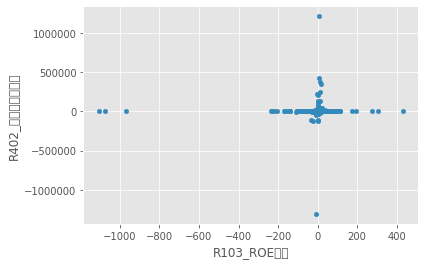

In [85]:
%matplotlib inline
dataset.plot.scatter(features[0], features[1])

## remove outliers and Scale features

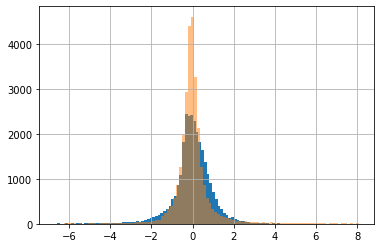

In [37]:
import pandas as pd
import sklearn.preprocessing as preprocessing
def is_valid(feature, nstd):
    ub = feature.mean() + nstd * feature.std()
    lb = feature.mean() - nstd * feature.std()
    return (feature > lb) & (feature <ub)
valid = is_valid(dataset['R103_ROE稅後'], 2) & is_valid(dataset['R402_營業毛利成長率'], 0.05)
# dataset_rmoutliers = dataset[valid]
# dataset_rmoutliers.plot.scatter(*features)
dataset_rmoutliers = dataset[valid].dropna()

# dataset_rmoutliers['R103_ROE稅後'].hist(bins=100)
# dataset_rmoutliers['R402_營業毛利成長率'].hist(bins=100)

dataset_scaled = pd.DataFrame(preprocessing.scale(dataset_rmoutliers), index=dataset_rmoutliers.index, columns=dataset_rmoutliers.columns)
# dataset_scaled.head()

dataset_scaled['R103_ROE稅後'].hist(bins=100)
dataset_scaled['R402_營業毛利成長率'].hist(bins=100, alpha=0.5)
dataset_scaled['return'] = dataset_rmoutliers['return']

## Training

In [84]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(dataset_scaled, test_size=0.1, random_state=0)

from sklearn.svm import SVC

cf = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=100, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# labels_train = dataset_train['return'] > dataset_train['return'].quantile(0.5)
cf.fit(dataset_train[features], dataset_train['return'] > dataset_train['return'].quantile(0.5))

/Users/wan/anaconda3/envs/finlab/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=100, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [81]:
cf.score(dataset_test[features], dataset_test['return'] > dataset_test['return'].quantile(0.5))

0.5100237852531431

# Plot decision region

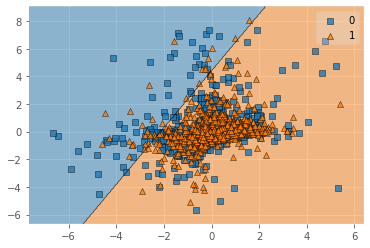

In [83]:
from mlxtend.plotting import plot_decision_regions

features_plot = dataset_test[features].values
labels_plot = (dataset_test['return'] > dataset_test['return'].quantile(0.5)).astype(int).values

plot_decision_regions(features_plot, labels_plot, cf)

# backtest

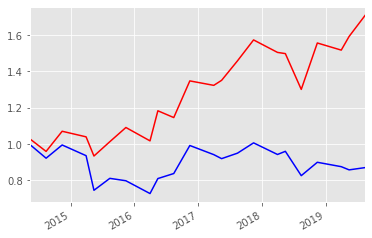

In [69]:
history = dataset_test.copy()
history['svm prediction'] = cf.predict(dataset_test[features])
history = history.reset_index()

dates = sorted(list(set(history['date'])))

seasonal_returns1 = []
seasonal_returns2 = []
for date in dates:
    current_stocks = history[history['date'] == date]
    # print(current_stocks)
    buy_stocks = current_stocks[current_stocks['svm prediction'] == True]
    sell_stocks = current_stocks[current_stocks['svm prediction'] == False]
    
    seasonal_return1 = buy_stocks['return'].mean()
    seasonal_returns1.append(seasonal_return1)
    
    seasonal_return2 = sell_stocks['return'].mean()
    seasonal_returns2.append(seasonal_return2)

import matplotlib.pyplot as plt
plt.style.use("ggplot")

pd.Series(seasonal_returns1, index=dates).cumprod().plot(color='red')
pd.Series(seasonal_returns2, index=dates).cumprod().plot(color='blue')